In [572]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier

### Data preparation

In [441]:
df = pd.read_excel('hotel_booking_data_cleaned 1.xlsx')

In [442]:
df.isna().sum().sort_values(ascending=False)[:5]

company               112593
agent                  16340
country                  488
children                   4
reserved_room_type         0
dtype: int64

In [577]:
clean_df = df.dropna(subset=['children']).copy()
# clean_df['thru_agent'] = 1
# clean_df.loc[clean_df['agent'].isna(), 'thru_agent'] = 0
# clean_df['company_order'] = 1
# clean_df.loc[clean_df['company'].isna(), 'company_order'] = 0
# clean_df = clean_df.drop(columns=['agent', 'company'])

In [578]:
clean_df['total_bookings'] = clean_df['previous_cancellations'] + clean_df['previous_bookings_not_canceled']
clean_df['country'].fillna(clean_df['country'].mode()[0], inplace=True)
clean_df['agent'].fillna(clean_df['agent'].mode()[0], inplace=True)
clean_df['company'].fillna(clean_df['company'].mode()[0], inplace=True)

In [579]:
clean_df['arrival_date'] = clean_df['arrival_date_year'].astype(str)+'-'+clean_df['arrival_date_month'].astype(str)+'-'+clean_df['arrival_date_day_of_month'].astype(str)
clean_df['arrival_date'] = pd.to_datetime(clean_df['arrival_date'])
clean_df['reservation_status_date'] = pd.to_datetime(clean_df['reservation_status_date'])
clean_df = clean_df.rename(columns={'reservation_status_date':'final_status_date'})
clean_df['stay_duration'] = clean_df['final_status_date'] - clean_df['arrival_date']
clean_df['stay_duration'] = clean_df['stay_duration'] / np.timedelta64(1, 'D')
clean_df['stay_duration'] = clean_df['stay_duration'].astype(int)
clean_df.loc[clean_df['stay_duration'] < 0, 'stay_duration'] = -1

In [580]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

### EDA & Visualization

In [581]:
def cancellation_dist_bar(var):
    plt.figure(figsize=(10,3))
    ax = sns.countplot(data=clean_df, x=var, hue='is_canceled')
    type_lst = list(set(clean_df[var]))
    for i in range(len(type_lst)):
        tmp = clean_df[(clean_df[var]==type_lst[i]) & (clean_df['is_canceled']==1)]
        print('Cancelations in', type_lst[i], '=', (len(tmp))/(len(clean_df[clean_df[var]==type_lst[i]])))

In [582]:
def cacellation_dist_facet(var, bin):
    plt.figure(figsize=(10,3))
    grid = sns.FacetGrid(clean_df, col='is_canceled')
    grid.map(plt.hist, var, width=50, bins=bin)
    grid.add_legend()

#### Time-related factors

In [317]:
(clean_df.groupby('arrival_date_month')['is_canceled'].sum() / clean_df.groupby('arrival_date_month')['is_canceled'].count()).sort_values(ascending=False)

arrival_date_month
June         0.414572
April        0.407972
May          0.396658
September    0.391702
October      0.380466
August       0.377352
July         0.374536
December     0.349705
February     0.334160
March        0.321523
November     0.312334
January      0.304773
Name: is_canceled, dtype: float64

Cancelations in 2016 = 0.3586329730015695
Cancelations in 2017 = 0.38697864182662767
Cancelations in 2015 = 0.37004365223717717


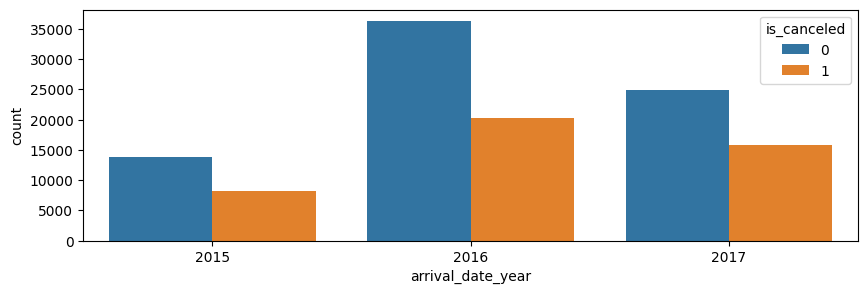

In [318]:
cancellation_dist_bar('arrival_date_year')

<Figure size 1000x300 with 0 Axes>

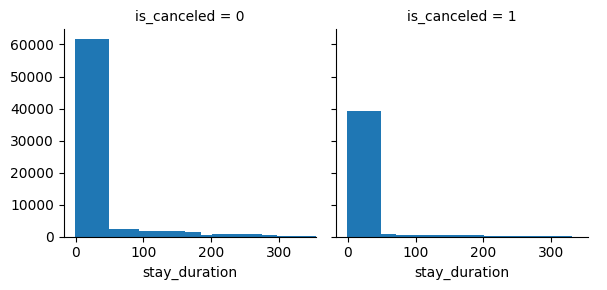

In [319]:
cacellation_dist_facet('stay_duration', 15)

<Figure size 1000x300 with 0 Axes>

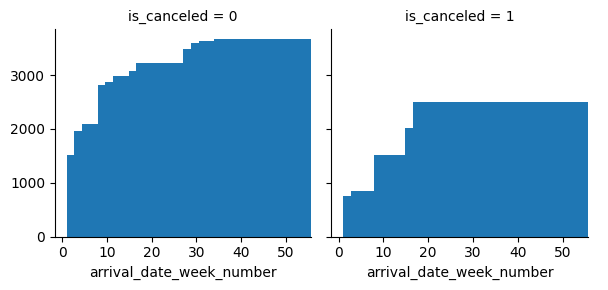

In [320]:
cacellation_dist_facet('arrival_date_week_number', 30)

<Figure size 1000x300 with 0 Axes>

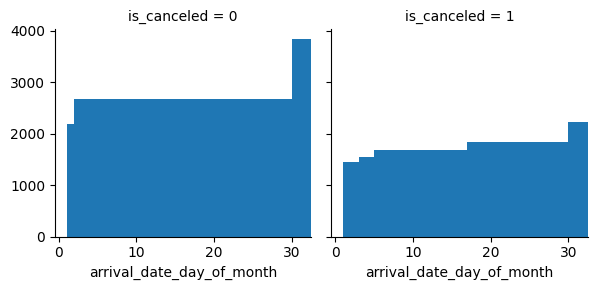

In [321]:
cacellation_dist_facet('arrival_date_day_of_month', 30)

<Figure size 1000x300 with 0 Axes>

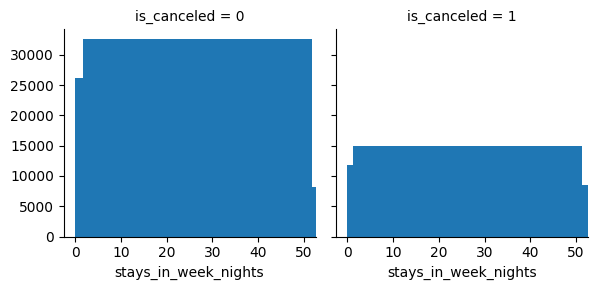

In [322]:
cacellation_dist_facet('stays_in_week_nights', 30)

<Figure size 1000x300 with 0 Axes>

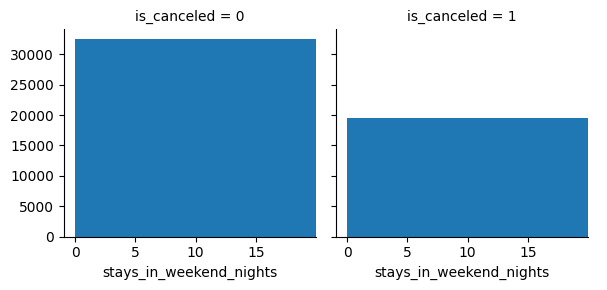

In [323]:
cacellation_dist_facet('stays_in_weekend_nights', 30)

<Figure size 1000x300 with 0 Axes>

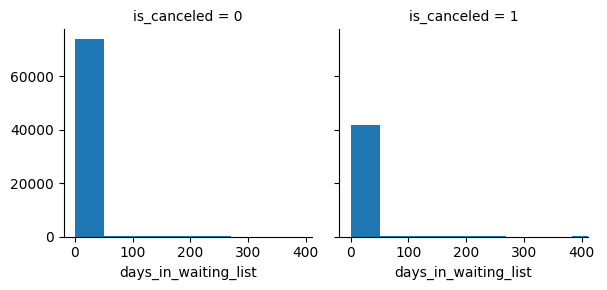

In [324]:
cacellation_dist_facet('days_in_waiting_list', 50)

<Figure size 1000x300 with 0 Axes>

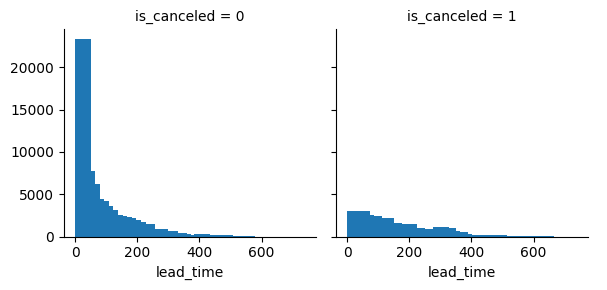

In [325]:
cacellation_dist_facet('lead_time', 50)

Text(0, 0.5, 'lead_time')

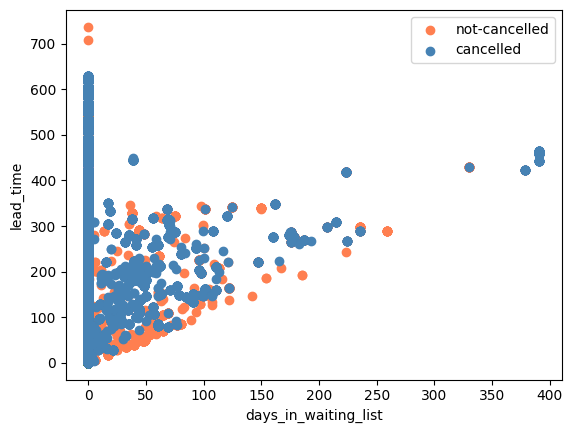

In [326]:
plt.scatter(clean_df[clean_df['is_canceled']==0]['days_in_waiting_list'], clean_df[clean_df['is_canceled']==0]['lead_time'], c='coral')
plt.scatter(clean_df[clean_df['is_canceled']==1]['days_in_waiting_list'], clean_df[clean_df['is_canceled']==1]['lead_time'], c='steelblue')
plt.legend(["not-cancelled" , "cancelled"])
plt.xlabel("days_in_waiting_list")
plt.ylabel("lead_time")

Cancelations in 1 = 0.34089157952669236
Cancelations in 2 = 0.3285948996356883
Cancelations in 3 = 0.36121955753857593
Cancelations in 4 = 0.411676102425596
Cancelations in 5 = 0.4063980439101421
Cancelations in 6 = 0.39484907227914706
Cancelations in 7 = 0.3227494519482356


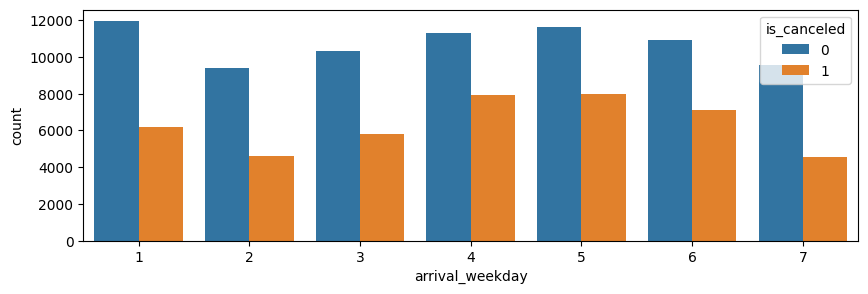

In [584]:
clean_df['arrival_weekday'] = clean_df['arrival_date'].dt.weekday + 1
cancellation_dist_bar('arrival_weekday')
clean_df['arrival_weekday'] = clean_df['arrival_weekday'].astype(str)

In [585]:
clean_df = clean_df.drop(columns=['arrival_date_week_number', 'stay_duration', 'stays_in_week_nights', 'arrival_date_day_of_month', 'days_in_waiting_list', 'stays_in_weekend_nights', 'arrival_date', 'final_status_date'])
# 'arrival_date_year', 'arrival_date_month'

#### Categorical features

In [328]:
clean_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'adults', 'children', 'babies',
       'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status', 'thru_agent',
       'company_order'],
      dtype='object')

Cancelations in Refundable = 0.2222222222222222
Cancelations in Non Refund = 0.9936244601357374
Cancelations in No Deposit = 0.2837428443093743


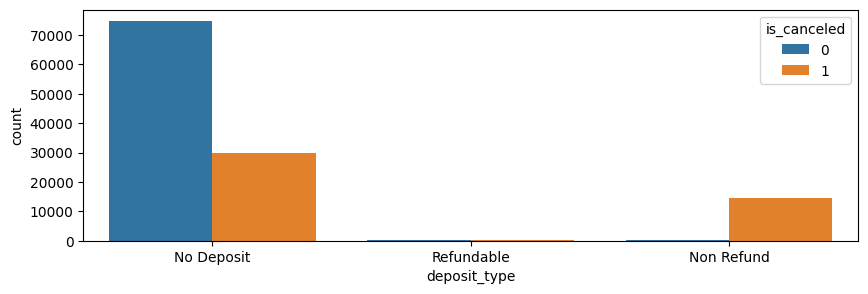

In [329]:
cancellation_dist_bar('deposit_type')

Cancelations in City Hotel = 0.4172402490986562
Cancelations in Resort Hotel = 0.27763354967548676


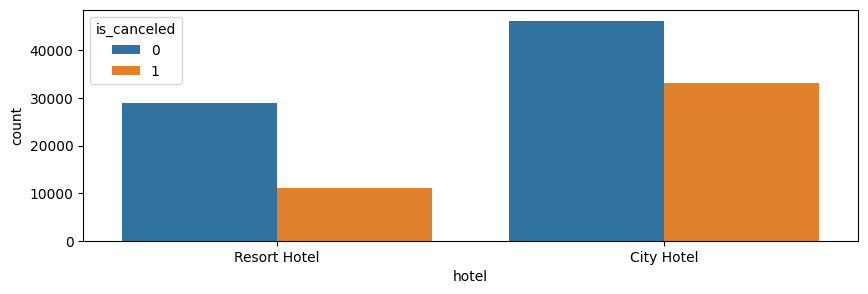

In [330]:
cancellation_dist_bar('hotel')

Cancelations in Check-Out = 0.0
Cancelations in No-Show = 1.0
Cancelations in Canceled = 1.0


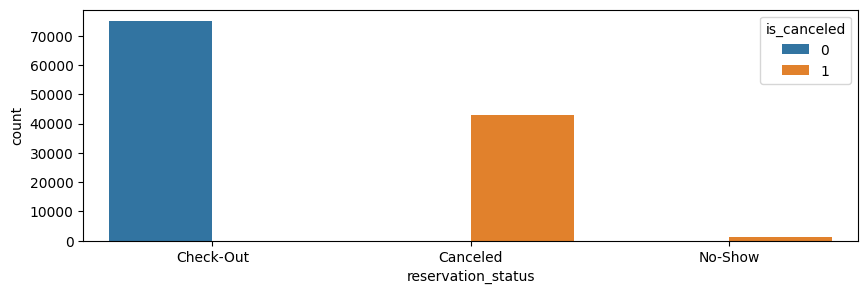

In [331]:
cancellation_dist_bar('reservation_status')

Cancelations in B = 0.23529411764705882
Cancelations in F = 0.24713409757398028
Cancelations in K = 0.043010752688172046
Cancelations in L = 1.0
Cancelations in G = 0.30552291421856637
Cancelations in H = 0.35252808988764045
Cancelations in D = 0.2512439775689124
Cancelations in A = 0.44492458104330684
Cancelations in P = 1.0
Cancelations in C = 0.18778947368421053
Cancelations in I = 0.013774104683195593
Cancelations in E = 0.2521137586471945


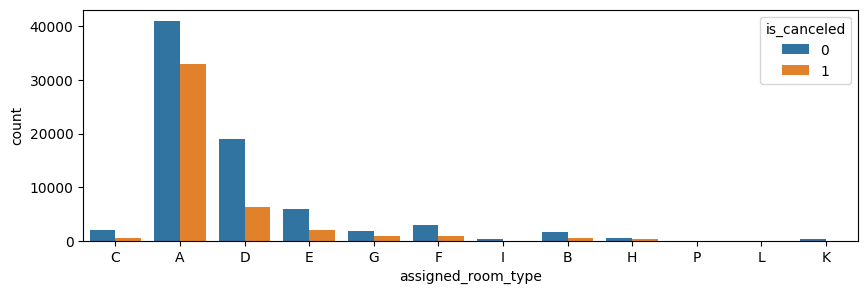

In [332]:
cancellation_dist_bar('assigned_room_type')

Cancelations in B = 0.3267504488330341
Cancelations in F = 0.30376251294442524
Cancelations in L = 0.3333333333333333
Cancelations in G = 0.3643744030563515
Cancelations in H = 0.40765391014975044
Cancelations in D = 0.3177959481277017
Cancelations in A = 0.3910737958462218
Cancelations in P = 1.0
Cancelations in C = 0.33047210300429186
Cancelations in E = 0.29288446824789593


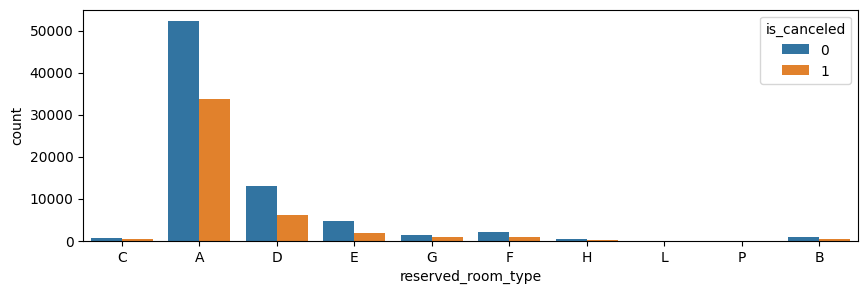

In [333]:
cancellation_dist_bar('reserved_room_type')

Cancelations in 0 = 0.05376416169471073
Cancelations in 1 = 0.4156065435679484


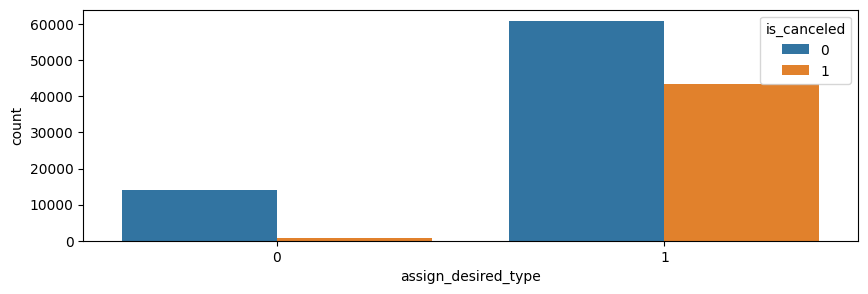

In [586]:
clean_df['assign_desired_type'] = 0
clean_df.loc[clean_df['reserved_room_type']==clean_df['assigned_room_type'], 'assign_desired_type'] = 1
cancellation_dist_bar('assign_desired_type')

Cancelations in Transient-Party = 0.2541799363057325
Cancelations in Contract = 0.3096172718351325
Cancelations in Group = 0.1022530329289428
Cancelations in Transient = 0.4074632028835102


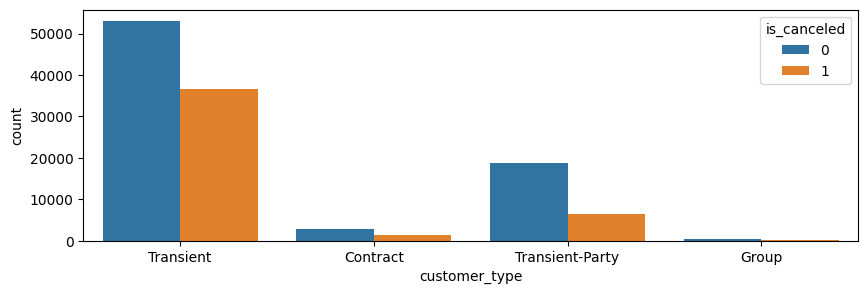

In [335]:
cancellation_dist_bar('customer_type')

Cancelations in FB = 0.5989974937343359
Cancelations in HB = 0.3446034709258107
Cancelations in Undefined = 0.2446535500427716
Cancelations in SC = 0.3723943661971831
Cancelations in BB = 0.37382185340064567


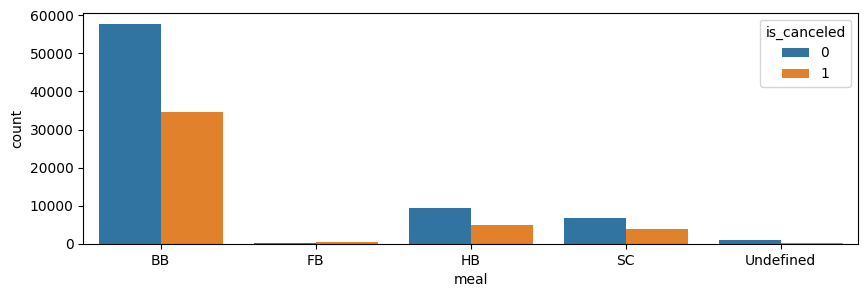

In [336]:
cancellation_dist_bar('meal')

Cancelations in TA/TO = 0.41025850618166954
Cancelations in GDS = 0.19170984455958548
Cancelations in Undefined = 0.0
Cancelations in Corporate = 0.22075782537067545
Cancelations in Direct = 0.17459883919426425


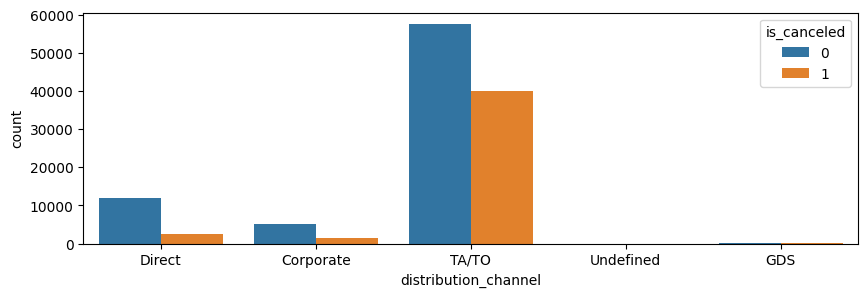

In [337]:
cancellation_dist_bar('distribution_channel')

Cancelations in Online TA = 0.3672002266449465
Cancelations in Groups = 0.6106203624249155
Cancelations in Offline TA/TO = 0.34316032866757507
Cancelations in Aviation = 0.21940928270042195
Cancelations in Complementary = 0.13055181695827725
Cancelations in Corporate = 0.1873465533522191
Cancelations in Direct = 0.15335184450614836


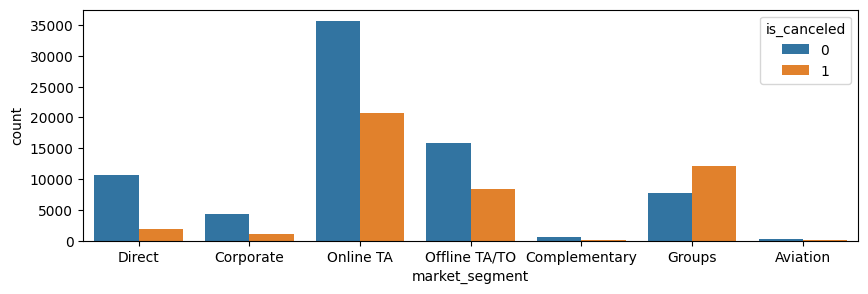

In [338]:
cancellation_dist_bar('market_segment')

Cancelations in 0 = 0.377829307122586
Cancelations in 1 = 0.14488188976377953


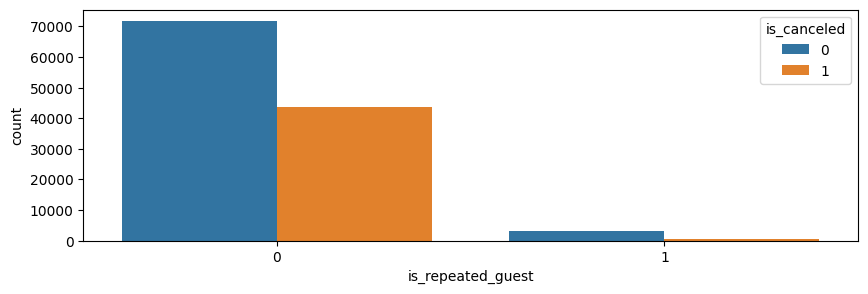

In [339]:
cancellation_dist_bar('is_repeated_guest')

Cancelations in 0 = 0.377829307122586
Cancelations in 1 = 0.14488188976377953


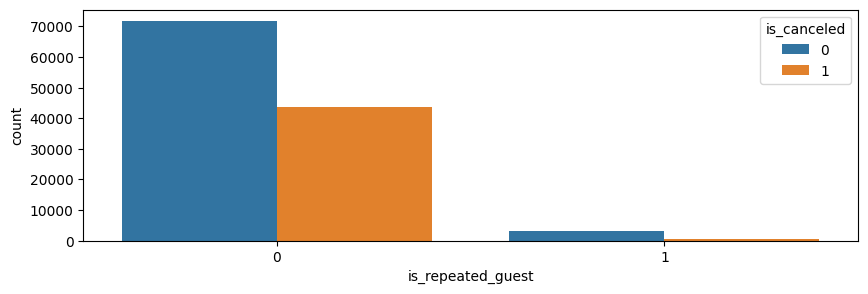

In [340]:
cancellation_dist_bar('is_repeated_guest')

Cancelations in 0 = 0.38217765501070267
Cancelations in 1 = 0.1752243636898632


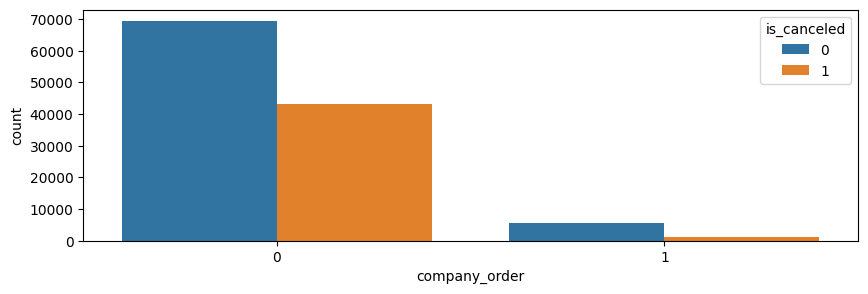

In [341]:
cancellation_dist_bar('company_order')

Cancelations in 0 = 0.24654180438242135
Cancelations in 1 = 0.3900318298268768


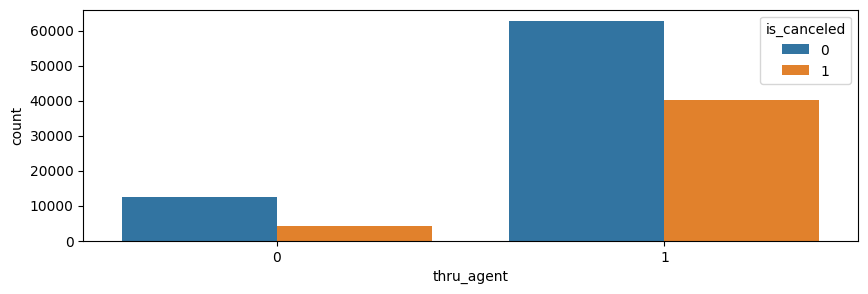

In [342]:
cancellation_dist_bar('thru_agent')

Cancelations in 0 = 0.39492721264624453
Cancelations in 1 = 0.0
Cancelations in 2 = 0.0
Cancelations in 3 = 0.0
Cancelations in 8 = 0.0


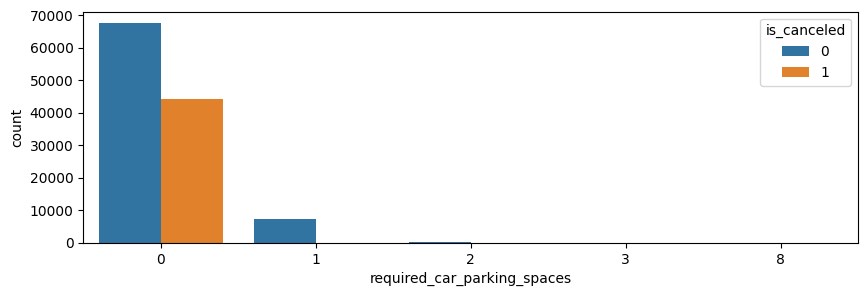

In [343]:
cancellation_dist_bar('required_car_parking_spaces')

In [414]:
clean_df.groupby('country').size().sort_values(ascending=False)

country
PRT    48586
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
MLI        1
MMR        1
MRT        1
SMR        1
PYF        1
Length: 177, dtype: int64

In [587]:
clean_df['new_country'] = 'other'
clean_df.loc[clean_df['country']=='PRT', 'new_country'] = 'PRT'
clean_df.loc[clean_df['country']=='GBR', 'new_country'] = 'GBR'

In [588]:
clean_df = clean_df.drop(columns=['reservation_status', 'country'])

#### Numerical features

In [589]:
clean_df['kids'] = clean_df['children'] + clean_df['babies']

Text(0, 0.5, 'num of adults')

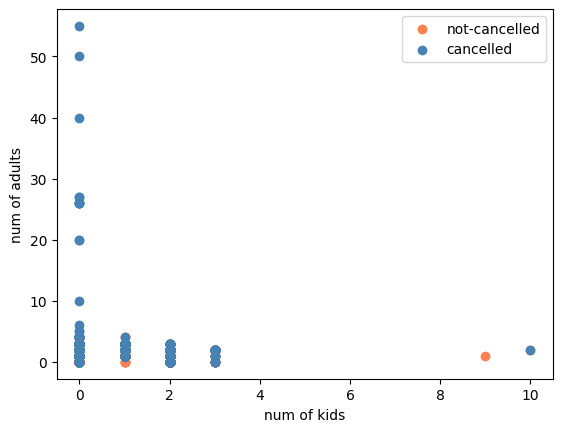

In [347]:
plt.scatter(clean_df[clean_df['is_canceled']==0]['kids'], clean_df[clean_df['is_canceled']==0]['adults'], c='coral')
plt.scatter(clean_df[clean_df['is_canceled']==1]['kids'], clean_df[clean_df['is_canceled']==1]['adults'], c='steelblue')
plt.legend(["not-cancelled" , "cancelled"])
plt.xlabel("num of kids")
plt.ylabel("num of adults")

Text(0, 0.5, 'previous_bookings_not_canceled')

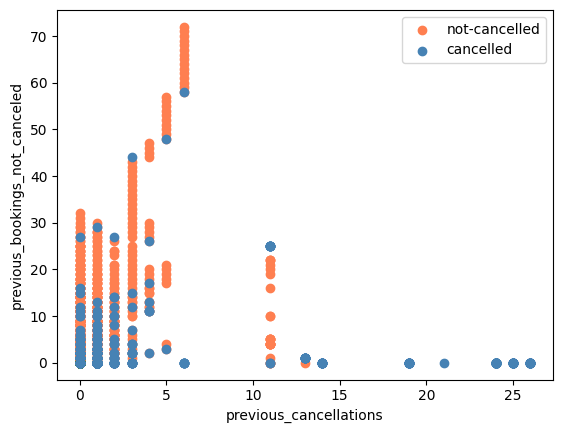

In [348]:
plt.scatter(clean_df[clean_df['is_canceled']==0]['previous_cancellations'], clean_df[clean_df['is_canceled']==0]['previous_bookings_not_canceled'], c='coral')
plt.scatter(clean_df[clean_df['is_canceled']==1]['previous_cancellations'], clean_df[clean_df['is_canceled']==1]['previous_bookings_not_canceled'], c='steelblue')
plt.legend(["not-cancelled" , "cancelled"])
plt.xlabel("previous_cancellations")
plt.ylabel("previous_bookings_not_canceled")

Text(0, 0.5, 'total_bookings')

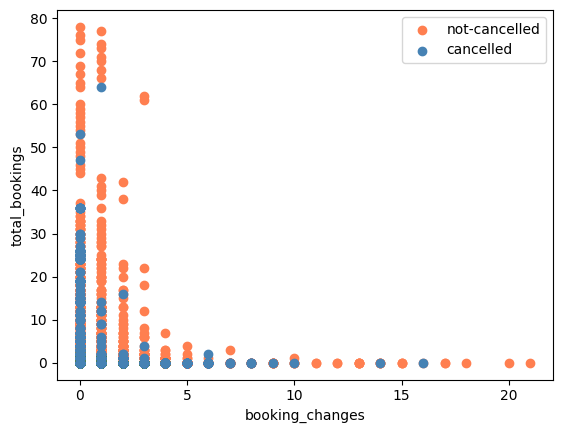

In [590]:
plt.scatter(clean_df[clean_df['is_canceled']==0]['booking_changes'], clean_df[clean_df['is_canceled']==0]['total_bookings'], c='coral')
plt.scatter(clean_df[clean_df['is_canceled']==1]['booking_changes'], clean_df[clean_df['is_canceled']==1]['total_bookings'], c='steelblue')
plt.legend(["not-cancelled" , "cancelled"])
plt.xlabel("booking_changes")
plt.ylabel("total_bookings")

Cancelations in 0 = 0.4772035609658978
Cancelations in 1 = 0.22017879180086086
Cancelations in 2 = 0.2209284392350401
Cancelations in 3 = 0.17861433720464556
Cancelations in 4 = 0.10588235294117647
Cancelations in 5 = 0.05


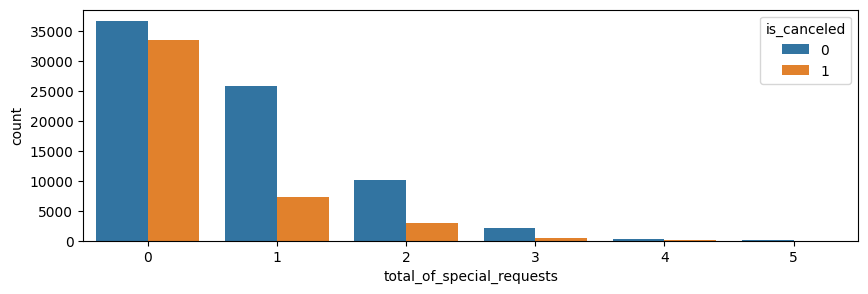

In [350]:
cancellation_dist_bar('total_of_special_requests')

Text(0, 0.5, 'num of reservation')

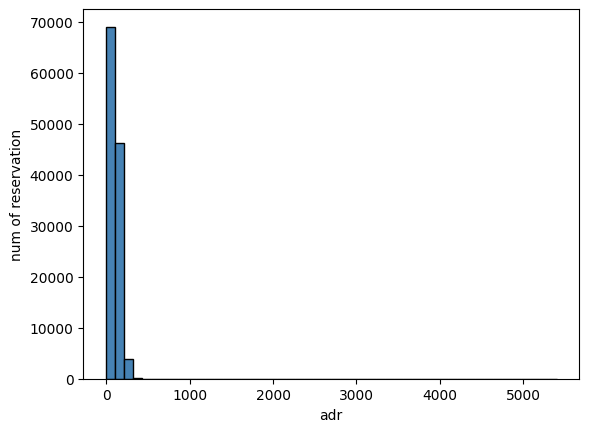

In [357]:
plt.hist(clean_df['adr'], color='steelblue', edgecolor='black', bins=50)
plt.xlabel('adr')
plt.ylabel('num of reservation')

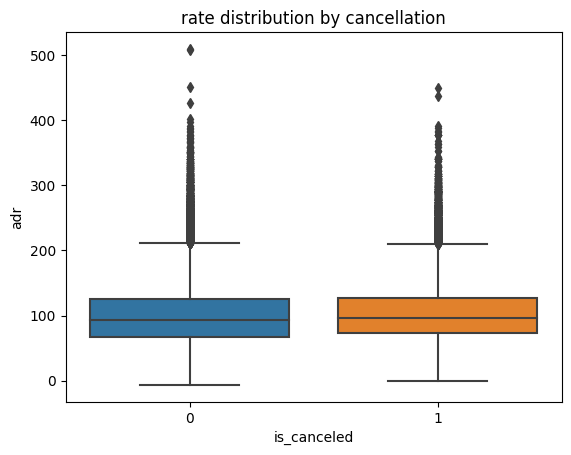

In [362]:
tmp = clean_df[clean_df['adr'] < 5000]
sns.boxplot(data=tmp, x="is_canceled", y="adr").set_title("rate distribution by cancellation")
plt.show()

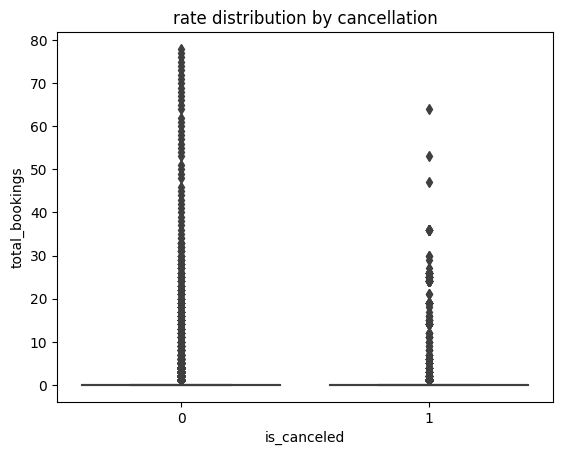

In [451]:
sns.boxplot(data=clean_df, x="is_canceled", y="total_bookings").set_title("rate distribution by cancellation")
plt.show()

In [591]:
clean_df = clean_df.drop(columns=['children', 'babies', 'kids', 'adr'])

### Preprocessing

In [563]:
clean_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'adults', 'meal', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_bookings', 'arrival_weekday',
       'new_country'],
      dtype='object')

In [592]:
cols = clean_df.columns
num_cols = clean_df._get_numeric_data().columns
cat_col = list(set(cols) - set(num_cols))

In [626]:
train_df_ = pd.get_dummies(clean_df, drop_first=1)

In [627]:
train_df_

,is_canceled,lead_time,arrival_date_year,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,...,customer_type_Transient,customer_type_Transient-Party,arrival_weekday_2,arrival_weekday_3,arrival_weekday_4,arrival_weekday_5,arrival_weekday_6,arrival_weekday_7,new_country_PRT,new_country_other
0,0,342,2015,2,0,0,0,3,9.0,40.0,...,1,0,0,1,0,0,0,0,1,0
1,0,737,2015,2,0,0,0,4,9.0,40.0,...,1,0,0,1,0,0,0,0,1,0
2,0,7,2015,1,0,0,0,0,9.0,40.0,...,1,0,0,1,0,0,0,0,0,0
3,0,13,2015,1,0,0,0,0,304.0,40.0,...,1,0,0,1,0,0,0,0,0,0
4,0,14,2015,2,0,0,0,0,240.0,40.0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,2,0,0,0,0,394.0,40.0,...,1,0,0,1,0,0,0,0,0,1
119386,0,102,2017,3,0,0,0,0,9.0,40.0,...,1,0,0,0,1,0,0,0,0,1
119387,0,34,2017,2,0,0,0,0,9.0,40.0,...,1,0,0,0,1,0,0,0,0,1
119388,0,109,2017,2,0,0,0,0,89.0,40.0,...,1,0,0,0,1,0,0,0,0,0


In [628]:
X = train_df_.drop(columns=['is_canceled'])
y = train_df_['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [629]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_mm = mm_scaler.transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

### Modeling

#### Train baseline models with cross validation
To avoid overfitting, I evaluate models with cross validation:

In [569]:
def get_mean_score(model, X_train, y_train):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    cross_val_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    return [cross_val_results['test_accuracy'].mean(), cross_val_results['test_precision'].mean(), cross_val_results['test_recall'].mean(), cross_val_results['test_f1_score'].mean()]

In [597]:
svc = LinearSVC()
sv_score = get_mean_score(svc, X_train_mm, y_train)

clf = LogisticRegression(max_iter=500, random_state=0)
logi_score = get_mean_score(clf, X_train_mm, y_train)

In [598]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn_score = get_mean_score(knn, X_train_std, y_train)

sgd = SGDClassifier()
sgd_score = get_mean_score(sgd, X_train, y_train)

decision_tree = DecisionTreeClassifier()
dt_score = get_mean_score(decision_tree, X_train, y_train)

random_forest = RandomForestClassifier()
rf_score = get_mean_score(random_forest, X_train, y_train)

gaussian = GaussianNB()
gnb_score = get_mean_score(gaussian, X_train, y_train)

model = xgb.XGBClassifier()
xgb_score = get_mean_score(model, X_train, y_train)

clf = GradientBoostingClassifier()
gbt_score = get_mean_score(clf, X_train, y_train)

In [599]:
pd.DataFrame({'metrics':['Accuracy', 'Precision', 'Recall', 'F1 score']
              , 'Logistic':logi_score, 'LinearSVC':sv_score, 'KNN':knn_score, 'SGD':sgd_score, 'DecisionT':dt_score, 'RandomForest':rf_score, 'Gaussian':gnb_score, 'XGBoost':xgb_score, 'GBTree':gbt_score})

,metrics,Logistic,LinearSVC,KNN,SGD,DecisionT,RandomForest,Gaussian,XGBoost,GBTree
0,Accuracy,0.807746,0.809146,0.817122,0.717733,0.851553,0.879507,0.619505,0.874856,0.852678
1,Precision,0.806996,0.813605,0.759416,0.784019,0.798563,0.861468,0.491695,0.853040,0.839305
2,Recall,0.630616,0.627300,0.739445,0.450710,0.800169,0.803112,0.874019,0.799053,0.743775
3,F1 score,0.707977,0.708398,0.749284,0.504236,0.799360,0.831260,0.629329,0.825148,0.788647


In [632]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
pd.DataFrame(zip(X_train.columns, clf.feature_importances_), columns=['feature', 'importance']).sort_values(by='importance', ascending=False).head(10)

,feature,importance
59,deposit_type_Non Refund,0.571237
34,market_segment_Online TA,0.065163
9,required_car_parking_spaces,0.062635
12,assign_desired_type,0.048015
70,new_country_PRT,0.030999
4,previous_cancellations,0.024012
62,customer_type_Transient,0.022567
10,total_of_special_requests,0.018111
31,market_segment_Direct,0.010240
35,distribution_channel_Direct,0.007255


#### Apply final model on testing data using grid search

In [635]:
params_rf = {'max_depth': [50, 60, 70, 80],
         'min_samples_leaf': [1, 2],
         'min_samples_split': [2, 5, 10],
}

In [636]:
random_forest = RandomForestClassifier()
grid_search = GridSearchCV(random_forest, params_rf, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best traing data accuracy:", grid_search.best_score_)
print("Test accuracy: {:.3f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best traing data accuracy: 0.8819072722278694
Test accuracy: 0.886


In [637]:
y_pred = grid_search.best_estimator_.predict(X_test)
print("Test data accuracy: ", accuracy_score(y_test, y_pred))
print("Test data recall: ", recall_score(y_test, y_pred))
print("Test data precision: ", precision_score(y_test, y_pred))

Test data accuracy:  0.8857810041118839
Test data recall:  0.8113915416098226
Test data precision:  0.8727072633895818


In [638]:
params = {
    'max_depth': [8, 9, 10, 12, 15],
    'learning_rate':[0.5, 0.3, 0.2, 0.1, 0.008, 0.005],
    'n_estimators': [600, 800, 1000]
    }

In [639]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600)
grid_search = GridSearchCV(xgb_clf, params, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best traing data accuracy:", grid_search.best_score_)
print("Test accuracy: {:.3f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 600}
Best traing data accuracy: 0.8828074199091727
Test accuracy: 0.886


In [640]:
y_pred = grid_search.best_estimator_.predict(X_test)
print("Test data accuracy: ", accuracy_score(y_test, y_pred))
print("Test data recall: ", recall_score(y_test, y_pred))
print("Test data precision: ", precision_score(y_test, y_pred))

Test data accuracy:  0.8861363520990914
Test data recall:  0.8278308321964529
Test data precision:  0.8608313235919989
